# Subduction example

The following example calculates the thermal structure of a subducting slab. It assumes here that we know the velocity - which is imposed as a (somewhat complicated) initial condition. Given an initial thermal structure, we then advect the temperature field in this flow, and observe the slab thermal structure.

Thus this is not a fully dynamic model, but represents a situation commonly found in geology/mineralogy/geophysics/geochemistry where some model of a subducting slab for different thermal conditions might be needed (for examples of the problem see Syracuse, van Keken and Abers, 2010: https://doi.org/10.1016/j.pepi.2010.02.004, albeit with a more complex approach).

In this example we set up a domain 500 km wide and 300 km deep. We set the mantle temperature to be 1400C, and impose two adjoining plates of ages 60 Myr and 80 Myr, and force convergence at 5 cm/yr.

In [1]:
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import planet_LB as p_LB

M2S = p_LB.Myr2s
Y2S = M2S/1e6
pLB = p_LB.planet_LB()


m=150
n=250
dx=2000 #2000
dy=2000 #2000
dist_x = dx*(n+1)
dist_y = dy*(m+1)
print("Domain length:\t",dist_x/1e3,"km")
H=0
kappa=1e-6 # Thermal diffusivity
age=1*M2S
dt = 500*Y2S
mstep = int(age/dt)
#mstep=40000 #40000
#dt = /mstep
print("Timestep:\t",dt/Y2S,"yr")
T0=1400
lb_s = pLB.LB_D2Q9_init_subduction(dt,m,n,dx,dy,T0,H,kappa,mstep)
print("mstep:\t\t",lb_s['mstep'])

T = np.ones_like(lb_s['T'])
X = lb_s['x']
Y = lb_s['y']

# Top and bottom temperatures
lb_s['T_top'] = 0.0
lb_s['T_base'] = T0

print("N M dx dy",n,m,dx,dy)

Domain length:	 502.0 km
Timestep:	 500.0 yr
mstep:		 2000
N M dx dy 250 150 2000 2000


## Plate thermal structure

We assume a plate thermal structure follows an error function (see Turcotte and Schubert for details on plate cooling), and initialise using that.  We have developed a routine (ini_slabs_T) that takes in the two plate ages, the distance in the x-direction at which they contact, and the inital temperature, and constructs the initial thermal field.

(251, 151)
Thickness of slab= 110.001 km
N M dx dy 250 150 2000 2000


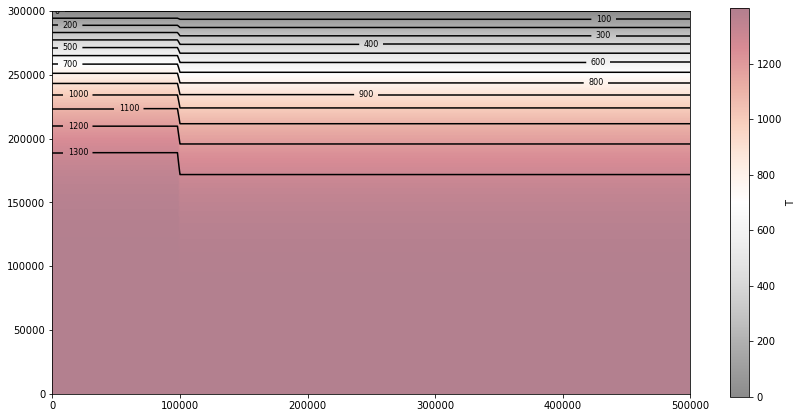

In [2]:
#Impose error function at surface for plate ages
plate_age1 = 60 * M2S # 50 MYr old plate
plate_age2 = 80 * M2S #110 yr old plate
distance = 100 *1e3 # 150 km - mid way along 300km section
Tinit = lb_s['T_base'] # Asthenosphere temperature

lb_s, thickness = pLB.init_slabs_T(lb_s, plate_age1, plate_age2, distance, Tinit)

T = lb_s["T"]
T_init = T
lb_s['T'] = T
lb_s['H'] = H

print(np.shape(lb_s['vx']))
#print(lb_s['T'])
print("Thickness of slab=",thickness/1e3,"km")
# View the initial condition
plt.figure(figsize=(12,8))
con1 = plt.contour(X,Y,T,15,colors='black')
plt.clabel(con1,inline=True,fontsize=8)
plt.imshow(lb_s['T'].T, extent=[0, n*dx, 0, m*dy], origin='lower', cmap='RdGy_r', alpha=0.5)

cbar=plt.colorbar(label='T',shrink=0.7);
plt.tight_layout()

print("N M dx dy",n,m,dx,dy)


## Velocity conditions

The following routine develops the velocity conditions for the problem. It takes in the thickness of the plates, the convergence velocity (here 5 cm/yr), the distance (position of subduction zone), and the angle of subduction. It calculates a velocity field in three sub-domains, the converging plate, the deep (pseudo-linear) plate, and the the curved hinge. 

We plot the velocity field below (for a lower sub-sample of the velocity field, to facilitate viewing).  Note the smoothness of the velocity field is fairly important - big jumps in imposed velocity will manifest as large temperature anomalies in the forced advection problem, so exercise caution in your flow field, and time-steps. 

In [3]:
cm_per_year = 1e-2/(365.35*25*60*60)
velocity = 5 * cm_per_year
#print(velocity)
angle = 45
lb_s = pLB.define_subduction_velocity_smooth(lb_s,thickness,velocity,angle,distance)
print(np.shape(lb_s['vx']))

yphi 251.67217955595214 45.0 r 165.0015 y1 134.9985
d1 [[468345.8591119 468345.8591119 468345.8591119 ... 468345.8591119
  468345.8591119 468345.8591119]
 [466345.8591119 466345.8591119 466345.8591119 ... 466345.8591119
  466345.8591119 466345.8591119]
 [464345.8591119 464345.8591119 464345.8591119 ... 464345.8591119
  464345.8591119 464345.8591119]
 ...
 [-27654.1408881 -27654.1408881 -27654.1408881 ... -27654.1408881
  -27654.1408881 -27654.1408881]
 [-29654.1408881 -29654.1408881 -29654.1408881 ... -29654.1408881
  -29654.1408881 -29654.1408881]
 [-31654.1408881 -31654.1408881 -31654.1408881 ... -31654.1408881
  -31654.1408881 -31654.1408881]]
(251, 151)


502000
2000 251


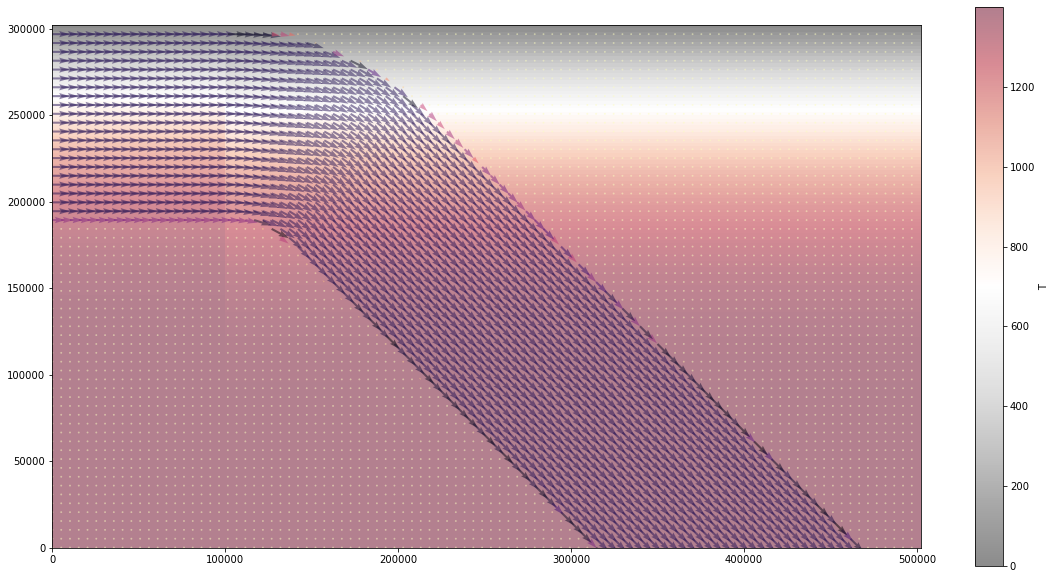

In [4]:
vxl = lb_s['vx']
vyl = lb_s['vy']
vmag = np.sqrt(vxl**2 + vyl**2)


plt.figure(figsize=(16,10))
#con1 = plt.contour(X,Y,T,15,colors='black',alpha=0.3)
#plt.clabel(con1,inline=True,fontsize=8)
plt.imshow(lb_s['T'].T, extent=[0, (n+1)*dx, 0, (m+1)*dy], origin='lower', cmap='RdGy_r', alpha=0.5)
cbar=plt.colorbar(label='T',shrink=0.8);

print(dist_x)
print(dx,n+1)

x_v = np.linspace(0,dist_x,100)
y_v = np.linspace(0,dist_y,60)
X_v,Y_v = np.meshgrid(x_v,y_v)

vxL = griddata((X.ravel(),Y.ravel()), vxl.ravel(), (X_v.ravel(),Y_v.ravel()), method='cubic')
vyL = griddata((X.ravel(),Y.ravel()), vyl.ravel(), (X_v.ravel(),Y_v.ravel()), method='cubic')
vxL = vxL.reshape(X_v.shape)
vyL = vyL.reshape(Y_v.shape)
vmagL =np.sqrt(vxL*vxL + vyL*vyL)

q1 = plt.quiver(X_v, Y_v, vxL, vyL, vmagL, alpha=0.5,cmap = 'magma_r')
#plt.contour(X,Y,vxl,15,colors='magenta')
#plt.scatter(X,Y,s=vmag*1e9,c='magenta')
#cbar=plt.colorbar(label='T',shrink=0.8);
plt.tight_layout()

#print(vxl)
#print(vyl)


## Running the simulation

Now we can run the subduction simulation. We set up our timestep (100 yrs) and our required simulation time (10 Myrs of subduction). 
We then run our bespoke LB solver for the problem (LB_D2Q9_Subduction - which solves the thermal field for an advective input)

In [ ]:
lb_s['vx0'] = vxl 
lb_s['vy0'] = vyl

lb_s['dt'] = 100*Y2S
age=10
lb_s = pLB.update_time(age,lb_s)
print('age:',age,'Myr   dt:',lb_s['dt']/Y2S,'mstep',lb_s['mstep'])
f=lb_s['f']
mstep = lb_s['mstep']
for i in range(mstep):
    lb_s['T']=T
    lb_s['f']=f
    #lb_s =  pLB.LB_D2Q9_T(lb_s)
    lb_s =  pLB.LB_D2Q9_Subduction(lb_s)
    T=lb_s['T']
    f=lb_s['f']
    if i % 1000 == 0:
        # Uncomment the following line to observe progress
        print("%d: %s" % (i,","))
        

age: 10 Myr   dt: 100.0 mstep 100000
0: ,
1000: ,
2000: ,
3000: ,
4000: ,
5000: ,
6000: ,
7000: ,
8000: ,
9000: ,
10000: ,
11000: ,
12000: ,
13000: ,
14000: ,
15000: ,
16000: ,
17000: ,
18000: ,
19000: ,
20000: ,
21000: ,
22000: ,
23000: ,
24000: ,
25000: ,
26000: ,
27000: ,
28000: ,
29000: ,
30000: ,
31000: ,
32000: ,
33000: ,
34000: ,
35000: ,
36000: ,
37000: ,
38000: ,
39000: ,
40000: ,
41000: ,
42000: ,
43000: ,
44000: ,
45000: ,
46000: ,
47000: ,
48000: ,
49000: ,
50000: ,
51000: ,
52000: ,
53000: ,
54000: ,
55000: ,
56000: ,
57000: ,
58000: ,
59000: ,
60000: ,
61000: ,
62000: ,
63000: ,
64000: ,
65000: ,
66000: ,
67000: ,
68000: ,
69000: ,
70000: ,
71000: ,
72000: ,
73000: ,
74000: ,
75000: ,
76000: ,
77000: ,
78000: ,
79000: ,
80000: ,
81000: ,
82000: ,
83000: ,
84000: ,
85000: ,
86000: ,
87000: ,
88000: ,
89000: ,
90000: ,
91000: ,
92000: ,
93000: ,
94000: ,
95000: ,
96000: ,
97000: ,
98000: ,
99000: ,


## Visualise the output

We can then visualise the output with the following:

In [ ]:
vxl = lb_s['vx']
vyl = lb_s['vy']
vmag = np.sqrt(vxl**2 + vyl**2)

T[T>1400] = 1400
plt.figure(figsize=(16,10))
con1 = plt.contour(X,Y,T ,15,colors='black',alpha=0.3)
plt.clabel(con1,inline=True,fontsize=8)
plt.imshow(T.T, extent=[0, (n+1)*dx, 0, (m+1)*dy], origin='lower', cmap='RdGy_r', alpha=0.5)
print(np.shape(T))

cbar=plt.colorbar(label='T',shrink=0.8);
plt.tight_layout()
plt.title("Age: %d" % (age) + "Myr")

## Obtaining temperatures along a path

Lastly, it is often important to obtain temperatures along a path, to compare, for instance, to metamorphic pseudo-sections from mineral-phase modelling software such as Perplex. Here we show a simple example of calculating the temperatures along a the slab cold core. One could use the slab surface, or back-calculate an advection path for a particle, to do the same.
Note the adiabatic gradient has not been added back in here - it may be my applying a 0.5 C/km term to the temperature with depth.


In [38]:
xsam = np.linspace(170000,428000,60)
ysam = np.linspace(300000,0,60)

Tsam = griddata((X.ravel(),Y.ravel()), T.ravel(), (xsam.ravel(),ysam.ravel()), method='cubic')


Text(0.5, 0, 'Temperature (C)')

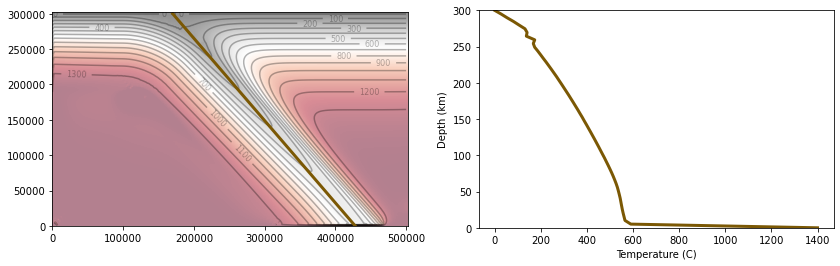

In [43]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

con1 = plt.contour(X,Y,T ,15,colors='black',alpha=0.3)
plt.clabel(con1,inline=True,fontsize=8)
plt.imshow(T.T, extent=[0, (n+1)*dx, 0, (m+1)*dy], origin='lower', cmap='RdGy_r', alpha=0.5)
plt.plot(xsam,ysam,linewidth=3,color="xkcd:shit brown")

plt.subplot(1,2,2)
plt.plot(Tsam,ysam/1e3,linewidth=3,color="xkcd:shit brown")
plt.ylim(0,300)
plt.ylabel("Depth (km)")
plt.xlabel("Temperature (C)")